In [1]:
import pandas as pd
import os

In [2]:
def load_nav(code):
    try:
        df = pd.read_pickle('data\%s.pkl'%code, compression='zip')
        df = df[['nav_date', 'adj_nav']]
        df['nav_date'] = pd.to_datetime(df['nav_date'])
        df.set_index('nav_date', inplace=True)
        df.sort_index(inplace=True)
        df.drop_duplicates(inplace=True)
        return df
    except Exception as e:
        print(e)
        return None

In [3]:
funds=pd.read_pickle('data\\funds.pkl')
funds300=pd.read_pickle('data\\funds300.pkl')
funds500=pd.read_pickle('data\\funds500.pkl')
funds1000=pd.read_pickle('data\\funds1000.pkl')
idx300=pd.read_pickle('data\\idx300.pkl')
idx500=pd.read_pickle('data\\idx500.pkl')
idx1000=pd.read_pickle('data\\idx1000.pkl')

In [6]:
def fund_prem_performance(funds, idx):
    idx_close = idx[['trade_date', 'close']].copy()
    idx_close['trade_date'] = pd.to_datetime(idx['trade_date'])
    idx_close.set_index('trade_date', inplace=True)
    idx_close.sort_index(inplace=True)
    idx_close.drop_duplicates(inplace=True)
    idx_close.columns = ['benchmark']
    nav_panel = None
    i=0
    for code in funds['ts_code']:
        nav = load_nav(code)
        if type(nav) is pd.DataFrame:
            i+=1
            # print(i, code, nav.shape)
            nav.columns = [code]
            if type(nav_panel) is type(None):
                nav_panel = nav
            else:
                nav_panel = nav_panel.merge(nav, left_index=True, right_index=True, how='outer')
            # print(nav_panel.shape)
    nav_panel.ffill(inplace=True)
    nav_panel = nav_panel.merge(idx_close, left_index=True, right_index=True, how='outer')
    nav_panel.ffill(inplace=True)
    ret_panel = nav_panel.pct_change()
    prem_panel = ret_panel.copy()
    for col in prem_panel.columns:
        prem_panel[col] = prem_panel[col] -  prem_panel['benchmark']
    prem_panel.drop('benchmark', axis=1, inplace=True)
    prem_sharpe = prem_panel.mean() / prem_panel.std()
    prem_cnt = prem_panel.count()
    prem_ann_ret = (prem_panel+1).cumprod().tail(1) ** (245 / prem_cnt) - 1
    prem_ann_ret = prem_ann_ret.transpose()
    prem_ann_ret.columns = ['ann_ret']
    prem_cnt.name = 'count'
    prem_stat = prem_ann_ret.merge(prem_cnt, left_index=True, right_index=True)
    prem_sharpe.name = 'sharpe'
    prem_stat = prem_stat.merge(prem_sharpe, left_index=True, right_index=True)
    prem_stat = prem_stat.merge(funds[['ts_code','name']], left_index=True, right_on='ts_code')
    return prem_stat, prem_panel


In [7]:
stat, panel = fund_prem_performance(funds300, idx300)

In [8]:
stat[stat['count']>500].sort_values('ann_ret')

,ann_ret,count,sharpe,ts_code,name
8115,-0.108619,717,-0.044126,007882.OF,易方达沪深300非银ETF联接C
12354,-0.059122,1444,-0.018398,960022.OF,博时裕富沪深300R
13343,-0.056033,1882,-0.008732,161721.OF,招商沪深300地产A
13841,-0.055695,2204,-0.019636,161718.OF,招商沪深300高贝塔
13272,-0.051045,1844,-0.015203,000950.OF,易方达沪深300非银ETF联接A
...,...,...,...,...,...
7010,0.086196,570,0.090525,008238.OF,中泰沪深300指数增强A
10804,0.089827,1318,0.071263,673100.OF,西部利得沪深300指数增强A
8455,0.090797,786,0.070759,007448.OF,长信沪深300指数增强C
9917,0.117565,1093,0.061097,004789.OF,富荣沪深300增强C


<AxesSubplot:>

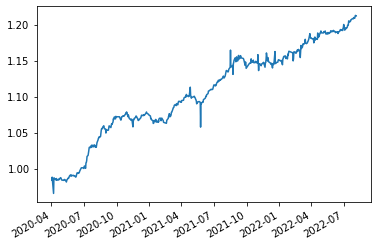

In [10]:
(panel['008238.OF']+1).cumprod().plot()

In [12]:
stat, panel = fund_prem_performance(funds500, idx500)

In [13]:
stat[stat['count']>500].sort_values('ann_ret')

,ann_ret,count,sharpe,ts_code,name
7287,-0.056847,2575,-0.022142,164809.OF,工银瑞信中证500ETF联接A
8945,-0.048978,867,-0.028375,006130.OF,华安中证500低波动ETF联接C
7504,-0.038893,2619,-0.004425,590007.OF,中邮中证500指数增强A
8944,-0.037729,867,-0.020483,006129.OF,华安中证500低波动ETF联接A
13079,-0.037243,1779,-0.005381,001052.OF,华夏中证500ETF联接A
...,...,...,...,...,...
8729,0.135339,830,0.096824,007089.OF,国投瑞银中证500量化增强C
7065,0.137316,577,0.105029,007995.OF,华夏中证500指数增强C
7041,0.141702,577,0.109602,007994.OF,华夏中证500指数增强A
9472,0.143848,980,0.092505,005994.OF,国投瑞银中证500量化增强A


<AxesSubplot:>

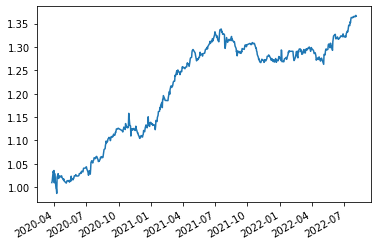

In [234]:
(panel['007994.OF']+1).cumprod().plot()

In [212]:
panel.corr()

,159620.OF,015508.OF,015507.OF,014587.OF,014588.OF,015454.OF,015453.OF,014305.OF,014306.OF,014018.OF,...,001241.OF,001214.OF,001052.OF,000962.OF,000478.OF,000008.OF,050025.OF,519034.OF,660011.OF,096001.OF
159620.OF,1.000000,0.671860,0.747432,0.641244,0.376937,0.832690,0.832487,0.994008,0.993304,0.756606,...,0.509051,0.208831,0.515103,0.185845,0.569440,0.410608,0.720163,0.524289,0.497357,0.805630
015508.OF,0.671860,1.000000,0.956987,0.720823,0.746138,0.897284,0.863155,0.812065,0.812978,0.453490,...,0.441258,0.221308,0.529500,0.177761,0.612839,0.180347,0.586052,-0.044965,0.370396,0.466351
015507.OF,0.747432,0.956987,1.000000,0.789550,0.756381,0.905211,0.871712,0.837553,0.838115,0.454022,...,0.437483,0.209052,0.615105,0.221577,0.542583,0.181330,0.570418,0.013924,0.419824,0.516425
014587.OF,0.641244,0.720823,0.789550,1.000000,0.834259,0.754142,0.752098,0.688443,0.687780,0.484484,...,0.547723,0.355074,0.484736,0.369244,0.446533,0.127181,0.417834,0.055473,0.420766,0.375275
014588.OF,0.376937,0.746138,0.756381,0.834259,1.000000,0.811517,0.766435,0.694024,0.695281,0.481508,...,0.357801,0.213713,0.524338,0.326233,0.438835,0.125935,0.364971,0.048434,0.378904,0.298533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000008.OF,0.410608,0.180347,0.181330,0.127181,0.125935,0.246866,0.340239,0.346902,0.348425,0.081178,...,0.149974,0.130500,0.176572,0.155910,0.126844,1.000000,0.293365,0.217758,0.176587,0.277337
050025.OF,0.720163,0.586052,0.570418,0.417834,0.364971,0.525748,0.525858,0.653360,0.653814,0.570329,...,0.268034,0.325956,0.446251,0.165410,0.164347,0.293365,1.000000,0.390597,0.272671,0.906613
519034.OF,0.524289,-0.044965,0.013924,0.055473,0.048434,0.185549,0.192296,0.273016,0.273916,0.247008,...,0.238358,0.231670,0.413405,0.110742,0.196925,0.217758,0.390597,1.000000,0.144449,0.384109
660011.OF,0.497357,0.370396,0.419824,0.420766,0.378904,0.600582,0.600845,0.583220,0.583426,0.266869,...,0.228662,0.166038,0.227272,0.318799,0.086875,0.176587,0.272671,0.144449,1.000000,0.301145


In [235]:
stat, panel = fund_prem_performance(funds1000, idx1000)

In [241]:
stat[stat['count']>500].sort_values('ann_ret')

,ann_ret,count,sharpe,ts_code,name
12955,-0.024308,1755,-0.011566,162413.OF,华宝中证1000A
9208,-0.022272,917,-0.015268,006487.OF,广发中证1000C
9210,-0.019909,917,-0.014215,006486.OF,广发中证1000A
10907,0.110616,1329,0.070244,004195.OF,招商中证1000指数增强C
10896,0.114866,1329,0.080093,004194.OF,招商中证1000指数增强A
9128,0.122370,902,0.095162,006166.OF,建信中证1000指数增强C
11195,0.123682,1375,0.073363,003647.OF,创金合信中证1000增强C
9114,0.125199,902,0.086851,006165.OF,建信中证1000指数增强A
11194,0.127677,1375,0.078103,003646.OF,创金合信中证1000增强A
9995,0.162120,1101,0.076869,005314.OF,万家中证1000指数增强C


<AxesSubplot:>

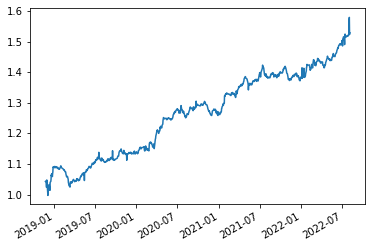

In [237]:
(panel['006166.OF']+1).cumprod().plot()

<AxesSubplot:>

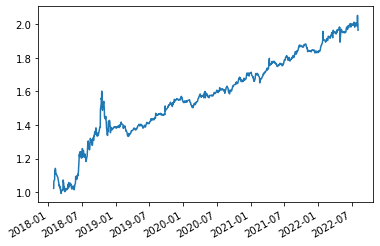

In [240]:
(panel['005314.OF']+1).cumprod().plot()